In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
DATA_PATH = './train/images/'
LAND_PATH = './train/landmarks.csv'

In [3]:
IMAGE_PATHS = np.array([os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH)])
LANDMARKS = pd.read_csv(LAND_PATH, sep='\t').set_index('file_name')

In [4]:
def show_image(file, title, rad=1, ax=None):
    src = cv2.imread(DATA_PATH + file)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    landmark = LANDMARKS.loc[file, :].values.reshape(971, 2)
    for i, (x, y) in enumerate(landmark):
        cv2.circle(src, (int(x), int(y)), rad, (0, 255, 0), -1)
        
    ax = ax or plt.gca()
    ax.set_title(title)
    ax.imshow(src)

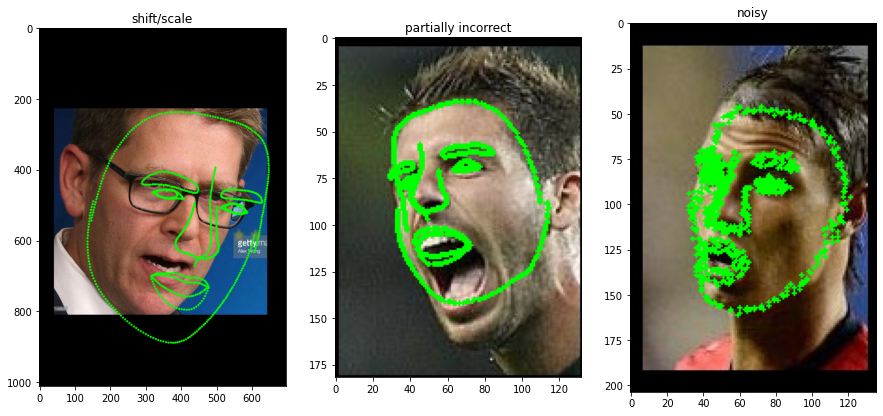

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

show_image('3e53c6ef5324d601b02c084e95ea4147.jpg', title='shift/scale', rad=3, ax=axes[0])
show_image('225a1d2faaa8f94e046f19546dc389ca.jpg', title='partially incorrect', ax=axes[1])
show_image('9bf446840146e01c50fc0556f456b66b.jpg', title='noisy', ax=axes[2])

In [6]:
def angle_variation(ps):
    dps = np.diff(ps, axis=0)
    angles = []
    for i in range(len(dps) - 1):
        e1, e2 = dps[i], dps[i+1]
        x = np.clip(e1.dot(e2)/(np.linalg.norm(e1) * np.linalg.norm(e2) + 0.00001), -1, 1)
        angle = math.acos(x)*180/math.pi
        angles.append(angle)

    return np.mean(angles)

In [7]:
stats = []

for image in tqdm(IMAGE_PATHS):
    img_file = image.split('/')[-1]
    img_landmark = LANDMARKS.loc[img_file].values.reshape(971, 2)
    stat1 = angle_variation(img_landmark[:64,:])
    stat2 = angle_variation(img_landmark[64:128,:])
    stats.append((img_file, stat1, stat2))

stats = np.array(stats)
stats = pd.DataFrame({'file': stats[:,0], 
                      'stat1': stats[:, 1].astype(float), 
                      'stat2': stats[:, 2].astype(float)})

100%|██████████| 64000/64000 [04:33<00:00, 234.34it/s]


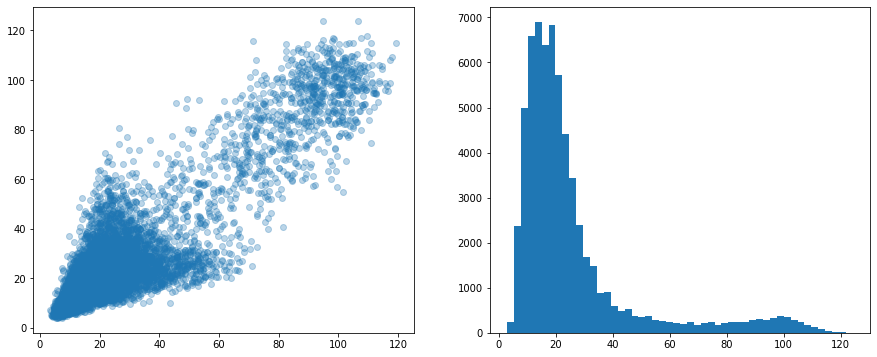

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].scatter(stats['stat1'].values[:10000], stats['stat2'].values[:10000], alpha=0.3)
axes[1].hist(stats['stat1'].values, bins=50)
plt.show()

In [10]:
smooth = stats[(stats['stat1'] < 40) & (stats['stat2'] < 40)].reset_index()
noisy = stats[(stats['stat1'] > 70) & (stats['stat2'] > 70)].reset_index()

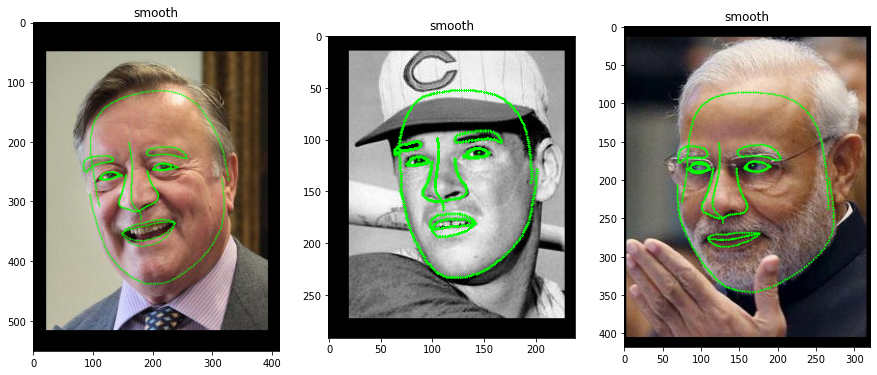

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

show_image(smooth['file'].values[0], title='smooth', rad=1, ax=axes[0])
show_image(smooth['file'].values[1], title='smooth', rad=1,ax=axes[1])
show_image(smooth['file'].values[2], title='smooth', rad=1,ax=axes[2])

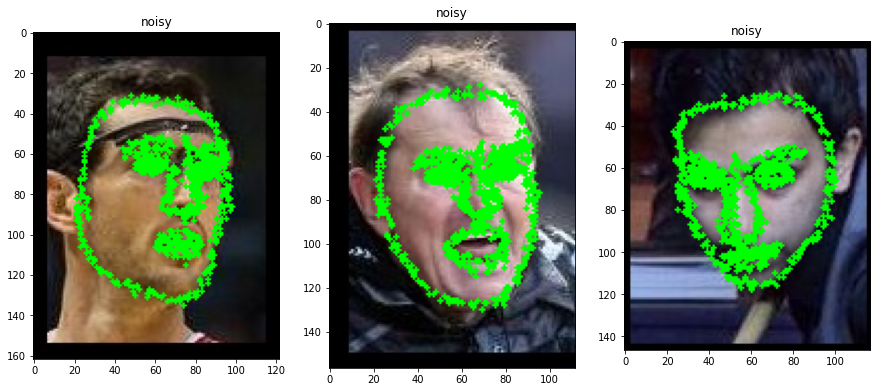

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

show_image(noisy['file'].values[0], title='noisy', rad=1, ax=axes[0])
show_image(noisy['file'].values[1], title='noisy', rad=1,ax=axes[1])
show_image(noisy['file'].values[2], title='noisy', rad=1,ax=axes[2])

In [13]:
noisy.shape

(3992, 4)

In [14]:
noisy.head()

,index,file,stat1,stat2
0,16,654963669ddae3612663a5c052116e83.jpg,108.274003,99.455247
1,49,102a4e7fdc8b34c6d8616a1cfdea2049.jpg,88.350043,105.276634
2,55,3eff69b4726b953ca536238105244278.jpg,106.201101,100.203363
3,66,0757ca8e9595715cb438821f97d9feea.jpg,103.103305,90.835021
4,94,0c39cc7ee599a683ee6abd622eb64b41.jpg,100.970543,105.891981


In [15]:
noisy['file'].values

array(['654963669ddae3612663a5c052116e83.jpg',
       '102a4e7fdc8b34c6d8616a1cfdea2049.jpg',
       '3eff69b4726b953ca536238105244278.jpg', ...,
       'e68841eb56cbae4ff593485e566e5cab.jpg',
       '028df4f84a2c8c0def9574cb23ee7f0a.jpg',
       '7253cf8e0429457c3826eb0621114b58.jpg'], dtype=object)

In [16]:
raise AssertionError
for i in noisy['file'].values:
    path = os.path.join(os.path.abspath(os.path.dirname(DATA_PATH)), i)
    os.remove(path)

In [26]:
LANDMARKS[~LANDMARKS.index.isin(noisy['file'].values)].to_csv("no_noise.csv", sep='\t')

In [20]:
no_noise = pd.read_csv("no_noise.csv")

In [21]:
no_noise.head()

,file_name,Point_0_X,Point_0_Y,Point_1_X,Point_1_Y,Point_2_X,Point_2_Y,Point_3_X,Point_3_Y,Point_4_X,...,Point_966_X,Point_966_Y,Point_967_X,Point_967_Y,Point_968_X,Point_968_Y,Point_969_X,Point_969_Y,Point_970_X,Point_970_Y
0,07c5e48d938e8d82c0f10973d66183f3.jpg,162,311,159,311,156,311,152,311,149,...,125,254,124,254,123,254,112,163,191,166
1,28e70684d6e2d6d75a6d3a973e4d4d93.jpg,90,376,89,375,85,374,84,374,82,...,87,307,85,309,87,310,96,202,162,203
2,e7696776dc7b15ca3fa80d4332443e96.jpg,123,210,121,210,119,211,117,211,115,...,98,175,97,175,95,176,80,119,128,115
3,199668f481aa5794c28657bace02fd84.jpg,109,203,107,203,105,203,103,203,101,...,75,159,73,158,73,157,75,107,129,106
4,9ebb7d722fa1cece4fa0d7b2fd39b399.jpg,59,127,58,126,56,126,55,126,53,...,44,92,43,91,43,91,58,61,84,68


In [23]:
land = pd.read_csv(LAND_PATH, sep='\t')

In [24]:
land.head()

,file_name,Point_0_X,Point_0_Y,Point_1_X,Point_1_Y,Point_2_X,Point_2_Y,Point_3_X,Point_3_Y,Point_4_X,...,Point_966_X,Point_966_Y,Point_967_X,Point_967_Y,Point_968_X,Point_968_Y,Point_969_X,Point_969_Y,Point_970_X,Point_970_Y
0,07c5e48d938e8d82c0f10973d66183f3.jpg,162,311,159,311,156,311,152,311,149,...,125,254,124,254,123,254,112,163,191,166
1,28e70684d6e2d6d75a6d3a973e4d4d93.jpg,90,376,89,375,85,374,84,374,82,...,87,307,85,309,87,310,96,202,162,203
2,e7696776dc7b15ca3fa80d4332443e96.jpg,123,210,121,210,119,211,117,211,115,...,98,175,97,175,95,176,80,119,128,115
3,199668f481aa5794c28657bace02fd84.jpg,109,203,107,203,105,203,103,203,101,...,75,159,73,158,73,157,75,107,129,106
4,9ebb7d722fa1cece4fa0d7b2fd39b399.jpg,59,127,58,126,56,126,55,126,53,...,44,92,43,91,43,91,58,61,84,68


In [25]:
no_noise.shape

(60008, 1943)